In [15]:
import pandas as pd
import numpy as np

# --------------------------------------------------
# 0. Helper: CSV loading + basic cleaning
# --------------------------------------------------
def load_dataset(filepath):
    """Load CSV and clean column names + basic missing values."""
    df = pd.read_csv(filepath)

    # Clean column names
    df.columns = (
        df.columns.str.strip()
                  .str.lower()
                  .str.replace(' ', '_')
                  .str.replace('[^a-zA-Z0-9_]', '', regex=True)
    )

    # Normalize common missing-value tokens
    df.replace(["", "NA", "N/A", "na", "NaN"], np.nan, inplace=True)

    return df

# --------------------------------------------------
# 1. Load pre-study questionnaire (Qualtrics)
# --------------------------------------------------
pre_path = "/Users/jane/Desktop/ACMMI/Qualtrics/-251123/preliminary: PRE-STUDY QUESTIONNAIRE_December 10, 2025.csv"

df_pre_raw = load_dataset(pre_path)

# Qualtrics: row 0 = question text, row 1 = ImportId; actual responses start from row 2
pre_quest_df = df_pre_raw.drop([0, 1]).reset_index(drop=True)

# Make sure all GAD-7 columns are kept as object first
for c in pre_quest_df.columns:
    if pre_quest_df[c].dtype == "object":
        pre_quest_df[c] = pre_quest_df[c].astype("object")

# --------------------------------------------------
# 2. Compute GAD-7 scores + anxiety level
# --------------------------------------------------
# Find all GAD-7 item columns (gad7_1 ~ gad7_7)
gad_cols = [col for col in pre_quest_df.columns if col.lower().startswith("gad7_")]

for c in gad_cols:
    # Extract only the first character (e.g., "1 - Not at all" → "1")
    pre_quest_df[c] = pre_quest_df[c].astype(str).str[0]
    # Handle variants of "nan"
    pre_quest_df[c] = pre_quest_df[c].replace(["n", "N", "nan", "NaN"], np.nan)
    # Missing → 0, then cast to int
    pre_quest_df[c] = pre_quest_df[c].fillna(0).astype(int)

# Total GAD-7 score
pre_quest_df["gad7_total"] = pre_quest_df[gad_cols].sum(axis=1)

# Map total score → anxiety level category
def gad_group(score):
    if score <= 4:
        return "minimal"
    elif score <= 9:
        return "mild"
    elif score <= 14:
        return "moderate"
    else:
        return "severe"

pre_quest_df["gad7_anxiety_level"] = pre_quest_df["gad7_total"].apply(gad_group)

# --------------------------------------------------
# 3. Extract GAD-7-only features and save to CSV
# --------------------------------------------------
gad7_features = pre_quest_df[[
    "participant_id",
    "gad7_total",
    "gad7_anxiety_level",
]].copy()

print("GAD-7 features preview:")
print(gad7_features.head())
print("Shape:", gad7_features.shape)

save_path = "/Users/jane/Desktop/ACMMI/Qualtrics/-251123/gad7_features_only.csv"


GAD-7 features preview:
  participant_id  gad7_total gad7_anxiety_level
0    test_summer           0            minimal
1   test_summer2           0            minimal
2          test4           0            minimal
3          test5           0            minimal
4          test6           0            minimal
Shape: (48, 3)


In [13]:
import re

def normalize_ids(df):
    df = df.copy()
    df["participant_id"] = (
        df["participant_id"]
        .astype(str)
        .str.strip()
        .str.lower()
    )
    return df

def keep_mit_ids(df):
    df = normalize_ids(df)
    mask = df["participant_id"].str.match(r"mit\d+", case=False)
    return df[mask].reset_index(drop=True)

gad7_mit = keep_mit_ids(gad7_features)

print("MIT only GAD-7 features:")
print(gad7_mit.head())
print("Shape:", gad7_mit.shape)

save_path_mit = "/Users/jane/Desktop/ACMMI/Qualtrics/-251123/gad7_features_MIT_only.csv"
gad7_mit.to_csv(save_path_mit, index=False)
print("Saved MIT-only GAD-7 file to:", save_path_mit)


MIT only GAD-7 features:
  participant_id  gad7_total gad7_anxiety_level
0         mit003           9               mild
1         mit004           3            minimal
2         mit005           4            minimal
3         mit006           7               mild
4         mit007           6               mild
Shape: (43, 3)
Saved MIT-only GAD-7 file to: /Users/jane/Desktop/ACMMI/Qualtrics/-251123/gad7_features_MIT_only.csv


GAD-7 features preview:
  participant_id  gad7_total gad7_anxiety_level
0    test_summer           0            minimal
1   test_summer2           0            minimal
2          test4           0            minimal
3          test5           0            minimal
4          test6           0            minimal
Shape: (48, 3)
Saved GAD-7-only file to: /Users/jane/Desktop/ACMMI/Qualtrics/-251123/gad7_features_only.csv


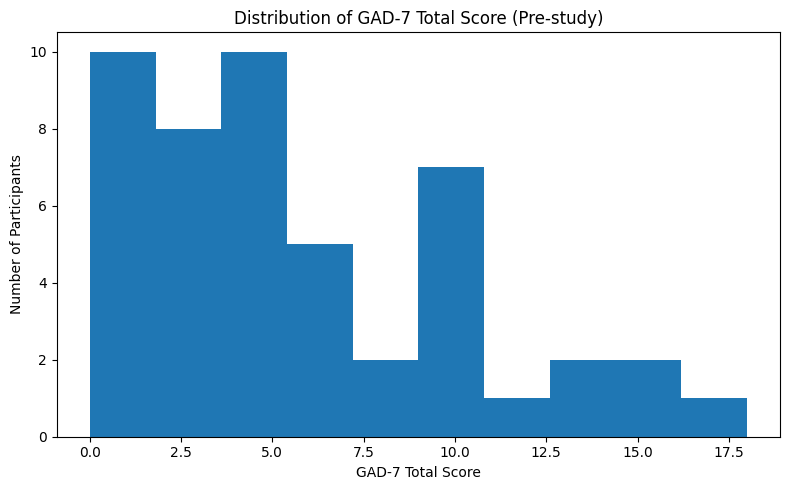

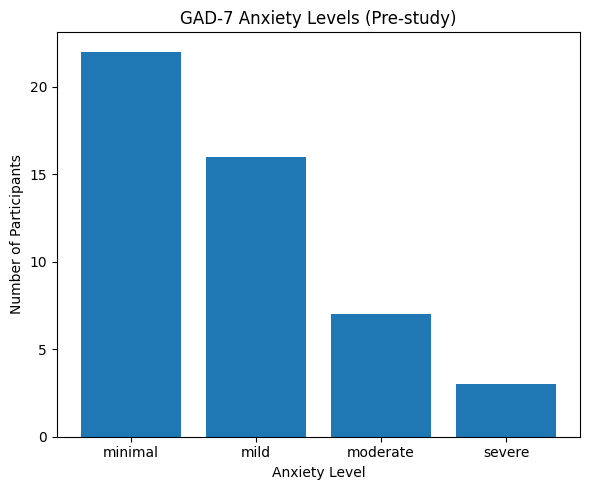


=== GAD-7 Summary (Pre-study) ===
Mean: 5.5625
Std : 4.635231638270684
Min : 0
Max : 18

Counts by anxiety level:
gad7_anxiety_level
minimal     22
mild        16
moderate     7
severe       3
Name: count, dtype: int64


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# 0. Helper: CSV loading + basic cleaning
# --------------------------------------------------
def load_dataset(filepath):
    """Load CSV and clean column names + normalize basic missing values."""
    df = pd.read_csv(filepath)

    # Clean column names
    df.columns = (
        df.columns.str.strip()
                  .str.lower()
                  .str.replace(' ', '_')
                  .str.replace('[^a-zA-Z0-9_]', '', regex=True)
    )

    # Normalize common missing-value tokens
    df.replace(["", "NA", "N/A", "na", "NaN"], np.nan, inplace=True)

    return df


# --------------------------------------------------
# 1. Load PRE-study questionnaire (Qualtrics)
# --------------------------------------------------
# TODO: update this path to the PRE file you want to use
pre_path = "/Users/jane/Desktop/ACMMI/Qualtrics/-251123/preliminary: PRE-STUDY QUESTIONNAIRE_December 10, 2025.csv"

df_pre_raw = load_dataset(pre_path)

# Qualtrics: row 0 = question text, row 1 = ImportId; actual responses start from row 2
pre_quest_df = df_pre_raw.drop([0, 1]).reset_index(drop=True)

# Ensure object type for safety
for c in pre_quest_df.columns:
    if pre_quest_df[c].dtype == "object":
        pre_quest_df[c] = pre_quest_df[c].astype("object")


# --------------------------------------------------
# 2. Compute GAD-7 scores + anxiety level
# --------------------------------------------------
# Find all GAD-7 item columns (gad7_1 ~ gad7_7)
gad_cols = [col for col in pre_quest_df.columns if col.lower().startswith("gad7_")]

for c in gad_cols:
    # Extract only the first character (e.g., "1 - Not at all" → "1")
    pre_quest_df[c] = pre_quest_df[c].astype(str).str[0]
    # Handle variants of "nan"
    pre_quest_df[c] = pre_quest_df[c].replace(["n", "N", "nan", "NaN"], np.nan)
    # Missing → 0, then cast to int
    pre_quest_df[c] = pre_quest_df[c].fillna(0).astype(int)

# Total GAD-7 score
pre_quest_df["gad7_total"] = pre_quest_df[gad_cols].sum(axis=1)

# Map total score → anxiety level category
def gad_group(score):
    if score <= 4:
        return "minimal"
    elif score <= 9:
        return "mild"
    elif score <= 14:
        return "moderate"
    else:
        return "severe"

pre_quest_df["gad7_anxiety_level"] = pre_quest_df["gad7_total"].apply(gad_group)

# Extract GAD-7-only features
gad7_features = pre_quest_df[[
    "participant_id",
    "gad7_total",
    "gad7_anxiety_level",
]].copy()

print("GAD-7 features preview:")
print(gad7_features.head())
print("Shape:", gad7_features.shape)


# --------------------------------------------------
# 3. (Optional) Keep only MIT participants
# --------------------------------------------------
def normalize_ids(df):
    df = df.copy()
    df["participant_id"] = (
        df["participant_id"]
        .astype(str)
        .str.strip()
        .str.lower()
    )
    return df

def keep_mit_ids(df):
    df = normalize_ids(df)
    mask = df["participant_id"].str.match(r"mit\d+", case=False)
    return df[mask].reset_index(drop=True)

# If you want MIT-only GAD-7 features, uncomment the next line:
# gad7_features = keep_mit_ids(gad7_features)


# --------------------------------------------------
# 4. Save GAD-7-only file
# --------------------------------------------------
save_path = "/Users/jane/Desktop/ACMMI/Qualtrics/-251123/gad7_features_only.csv"
gad7_features.to_csv(save_path, index=False)
print("Saved GAD-7-only file to:", save_path)


# --------------------------------------------------
# 5. Visualization: GAD-7 distribution
# --------------------------------------------------
# Histogram of GAD-7 total score
plt.figure(figsize=(8, 5))
plt.hist(gad7_features["gad7_total"], bins=10)
plt.title("Distribution of GAD-7 Total Score (Pre-study)")
plt.xlabel("GAD-7 Total Score")
plt.ylabel("Number of Participants")
plt.tight_layout()
plt.show()

# Bar chart of anxiety level counts
order = ["minimal", "mild", "moderate", "severe"]
gad7_features["gad7_anxiety_level"] = pd.Categorical(
    gad7_features["gad7_anxiety_level"],
    categories=order,
    ordered=True
)
level_counts = gad7_features["gad7_anxiety_level"].value_counts().sort_index()

plt.figure(figsize=(6, 5))
plt.bar(level_counts.index.astype(str), level_counts.values)
plt.title("GAD-7 Anxiety Levels (Pre-study)")
plt.xlabel("Anxiety Level")
plt.ylabel("Number of Participants")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 6. Summary statistics
# --------------------------------------------------
print("\n=== GAD-7 Summary (Pre-study) ===")
print("Mean:", gad7_features["gad7_total"].mean())
print("Std :", gad7_features["gad7_total"].std())
print("Min :", gad7_features["gad7_total"].min())
print("Max :", gad7_features["gad7_total"].max())
print("\nCounts by anxiety level:")
print(level_counts)
